## Final Model Code (XGBoost)

### Load Dataset

In [31]:
import numpy as np
import pandas as pd

In [32]:
loaded_df = pd.read_feather("/workspaces/student-group-project-jxckj/checkpoint2/large_df.feather")

# display the first few rows of the dataframe to confirm it loaded correctly
print("New DataFrame loaded from 'loaded_df.feather':")
loaded_df.head()

New DataFrame loaded from 'loaded_df.feather':


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,ADDRESS,ZIP_CODE,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,SALE_PRICE,SALE_DATE
1,2.0,BATHGATE,01 ONE FAMILY HOMES,441 EAST 178 STREET,10457.0,1287.0,2378.0,1899.0,116000.0,7/1/2010
2,2.0,BATHGATE,01 ONE FAMILY HOMES,4428 PARK AVENUE,10457.0,3525.0,1340.0,1899.0,287000.0,12/10/2010
3,2.0,BATHGATE,01 ONE FAMILY HOMES,467 EAST 185 STREET,10458.0,1667.0,1296.0,1910.0,150000.0,4/20/2010
4,2.0,BATHGATE,01 ONE FAMILY HOMES,2085 BATHGATE AVENUE,10457.0,2060.0,1629.0,1899.0,145915.0,7/27/2010
5,2.0,BATHGATE,01 ONE FAMILY HOMES,2069 BATHGATE AVENUE,10457.0,1964.0,1424.0,1899.0,72790.0,6/3/2010


### Geocode

In [33]:
import re

add_filtered = pd.read_csv("/workspaces/student-group-project-jxckj/_datasets/cleaned_addresses.csv")
add_filtered = add_filtered.dropna(subset=['latitude', 'longitude', 'borocode', 'zipcode', 'address'])
add_filtered.drop(['xcoord','ycoord'], axis=1)

# Function to clean and standardize addresses
def clean_address(address):
    if isinstance(address, str):  
        address = address.lower().strip()  
        address = " ".join(address.split()) 
        replacements = {
            " street": " st",
            " avenue": " ave",
            " boulevard": " blvd",
            " place": " pl",
            " road": " rd",
            " drive": " dr",
            " lane": " ln",
            " court": " ct",
            " parkway": " pkwy",
            " highway": " hwy"
        }

        for key, value in replacements.items():
            address = address.replace(key, value)
        
        address = address.replace(",", "").replace(".", "").replace("#", "")

    return address

add_filtered['address_clean'] = add_filtered['address'].apply(clean_address)
loaded_df['address_clean'] = loaded_df['ADDRESS'].apply(clean_address)

geo_df = pd.merge(
    add_filtered,loaded_df,
    left_on=['address_clean', 'zipcode'],
    right_on=['address_clean', 'ZIP_CODE'],
    how='inner'
)

# Ensure latitude and longitude are numeric (clean if necessary)
geo_df['latitude'] = pd.to_numeric(geo_df['latitude'], errors='coerce')
geo_df['longitude'] = pd.to_numeric(geo_df['longitude'], errors='coerce')

# Drop rows with missing coordinates
geo_df = geo_df.dropna(subset=['latitude', 'longitude'])

geo_df.head()

,latitude,longitude,borocode,xcoord,ycoord,zipcode,address,address_clean,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,ADDRESS,ZIP_CODE,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,SALE_PRICE,SALE_DATE
0,40.625779,-73.953658,3,997114.0,167268.0,11210.0,2220 AVENUE J,2220 ave j,3.0,MIDWOOD,01 ONE FAMILY HOMES,2220 AVENUE J,11210.0,5000.0,3322.0,1920.0,1510000.0,1/24/2012
1,40.622940,-73.957295,3,996105.0,166233.0,11230.0,1820 AVENUE K,1820 ave k,3.0,MIDWOOD,01 ONE FAMILY DWELLINGS,1820 AVENUE K,11230.0,4000.0,2466.0,1899.0,1800000.0,06/27/2024
2,40.629218,-73.922529,3,1005754.0,168527.0,11234.0,1098 EAST 56TH STREET,1098 east 56th st,3.0,FLATLANDS,41 TAX CLASS 4 - OTHER,1098 EAST 56TH STREET,11234.0,3575.0,0.0,1975.0,665000.0,12/13/2022
3,40.624338,-73.918932,3,1006754.0,166750.0,11234.0,5823 AVENUE L,5823 ave l,3.0,FLATLANDS,02 TWO FAMILY DWELLINGS,5823 AVENUE L,11234.0,2033.0,1216.0,1925.0,636540.0,11/22/2021
4,40.621260,-73.924894,3,1005100.0,165627.0,11234.0,5206 AVENUE M,5206 ave m,3.0,OLD MILL BASIN,01 ONE FAMILY DWELLINGS,5206 AVE M,11234.0,2000.0,1034.0,1920.0,380000.0,12/06/2024


In [34]:
# lat long grid feature 10x10
geo_df[['latitude', 'longitude']].describe()

# find min and max of lat and long
min_lat = geo_df['latitude'].min()
min_long = geo_df['longitude'].min()
max_lat = geo_df['latitude'].max()
max_long = geo_df['longitude'].max()

# 10x10 grid
lat_step = (max_lat - min_lat) / 10
long_step = (max_long - min_long) / 10

# assign grid
def assign_grid(lat, long):
    row = int((lat - min_lat) / lat_step)
    col = int((long - min_long) / long_step)
    grid_number = 10 * (row - 1) + col
    return grid_number

geo_df['grid'] = geo_df.apply(lambda row: assign_grid(row['latitude'], row['longitude']), axis = 1)

# geo_df.head()

In [35]:
large_df = geo_df.copy()

### Preprocessing

In [36]:
# Filter out obvious outliers
large_df = large_df[large_df['LAND_SQUARE_FEET'] > 1]
large_df = large_df[large_df['GROSS_SQUARE_FEET'] > 10]

# Clean up neighborhood names and remove unknowns
large_df['NEIGHBORHOOD'] = large_df['NEIGHBORHOOD'].fillna("").str.replace(" ", "")
large_df = large_df[~large_df['NEIGHBORHOOD'].str.contains("UNKNOWN", case=False)]

In [37]:
# floor area ratio
large_df['FAR'] = large_df['GROSS_SQUARE_FEET'] / large_df['LAND_SQUARE_FEET']
# recode boroughs as strings to prevent numerical analyses
d = {'2.0': 'BRONX', '1.0': 'MANHATTAN', '3.0': 'BROOKLYN', '4.0': 'QUEENS', '5.0': 'STATENISLAND'}
large_df['BOROUGH'] = large_df['BOROUGH'].astype(str) .replace(d)

In [38]:
# split date
def fix_year(date_str):
    if isinstance(date_str, str):
        parts=date_str.strip().split("/")
        if len(parts)==3 and len(parts[2])==2:
            parts[2]="20"+parts[2]
            return"/".join(parts)
    return date_str

large_df["SALE_DATE"]=large_df["SALE_DATE"].apply(fix_year)

large_df["SALE_DATE"]=pd.to_datetime(large_df["SALE_DATE"])

large_df["SALE_YEAR"]=large_df["SALE_DATE"].dt.year
large_df["SALE_MONTH"]=large_df["SALE_DATE"].dt.month
large_df["SALE_DAY"]=large_df["SALE_DATE"].dt.day

large_df.head()

,latitude,longitude,borocode,xcoord,ycoord,zipcode,address,address_clean,BOROUGH,NEIGHBORHOOD,...,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,SALE_PRICE,SALE_DATE,grid,FAR,SALE_YEAR,SALE_MONTH,SALE_DAY
0,40.625779,-73.953658,3,997114.0,167268.0,11210.0,2220 AVENUE J,2220 ave j,BROOKLYN,MIDWOOD,...,5000.0,3322.0,1920.0,1510000.0,2012-01-24,25,0.664400,2012,1,24
1,40.622940,-73.957295,3,996105.0,166233.0,11230.0,1820 AVENUE K,1820 ave k,BROOKLYN,MIDWOOD,...,4000.0,2466.0,1899.0,1800000.0,2024-06-27,25,0.616500,2024,6,27
3,40.624338,-73.918932,3,1006754.0,166750.0,11234.0,5823 AVENUE L,5823 ave l,BROOKLYN,FLATLANDS,...,2033.0,1216.0,1925.0,636540.0,2021-11-22,26,0.598131,2021,11,22
4,40.621260,-73.924894,3,1005100.0,165627.0,11234.0,5206 AVENUE M,5206 ave m,BROOKLYN,OLDMILLBASIN,...,2000.0,1034.0,1920.0,380000.0,2024-12-06,15,0.517000,2024,12,6
5,40.621192,-73.925845,3,1004836.0,165602.0,11234.0,5106 AVENUE M,5106 ave m,BROOKLYN,OLDMILLBASIN,...,2567.0,2320.0,1950.0,550000.0,2017-09-13,15,0.903779,2017,9,13


## Model - XGBoost

In [52]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error, r2_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Reload dataset
df = large_df.copy()
residential_categories = [
    '01 ONE FAMILY DWELLINGS', '02 TWO FAMILY DWELLINGS', '03 THREE FAMILY DWELLINGS',
    '04 TAX CLASS 1 CONDOS', '05 TAX CLASS 1 VACANT LAND', '06 TAX CLASS 1 - OTHER',
    '12 CONDOS - WALKUP APARTMENTS', '13 CONDOS - ELEVATOR APARTMENTS', '14 RENTALS - 4-10 UNIT',
    '15 CONDOS - 2-10 UNIT RESIDENTIAL', '16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT',
    '17 CONDO COOPS', '08 RENTALS - ELEVATOR APARTMENTS', '07 RENTALS - WALKUP APARTMENTS',
    '09 COOPS - WALKUP APARTMENTS', '10 COOPS - ELEVATOR APARTMENTS'
]
df['BUILDING_CLASS_CATEGORY'] = df['BUILDING_CLASS_CATEGORY'].str.strip().str.upper()
df = df[df['BUILDING_CLASS_CATEGORY'].isin(residential_categories)]

# Convert columns to numeric
df['GROSS_SQUARE_FEET'] = pd.to_numeric(df['GROSS_SQUARE_FEET'], errors='coerce')
df['LAND_SQUARE_FEET'] = pd.to_numeric(df['LAND_SQUARE_FEET'], errors='coerce')
df['SALE_PRICE'] = pd.to_numeric(df['SALE_PRICE'], errors='coerce')
df['YEAR_BUILT'] = pd.to_numeric(df['YEAR_BUILT'], errors='coerce')
df['ZIP_CODE'] = pd.to_numeric(df['ZIP_CODE'], errors='coerce')

# Filter for realistic data
df = df[(df['SALE_PRICE'] > 10000) & (df['SALE_PRICE'] < 10000000)]
df = df[(df['GROSS_SQUARE_FEET'] > 100) & (df['GROSS_SQUARE_FEET'] < 10000)]

# Drop missing values
df.dropna(subset=['GROSS_SQUARE_FEET', 'LAND_SQUARE_FEET', 'SALE_PRICE',
                  'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'YEAR_BUILT', 'ZIP_CODE'], inplace=True)

# Log-transform the target
df['LOG_SALE_PRICE'] = np.log1p(df['SALE_PRICE'])

# Define features and target
features = ['NEIGHBORHOOD', 'GROSS_SQUARE_FEET', 'LAND_SQUARE_FEET',
            'YEAR_BUILT', 'ZIP_CODE', 'BUILDING_CLASS_CATEGORY','grid']
target = 'LOG_SALE_PRICE'
X = df[features]
y = df[target]

# Preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), ['GROSS_SQUARE_FEET', 'LAND_SQUARE_FEET', 'YEAR_BUILT', 'ZIP_CODE','grid']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY'])
])

# XGBoost pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42))
])
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
pipeline.fit(X_train, y_train)

# 5-fold Cross-validation: Get R² + MAE
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='r2')
cv_mae_scores = -cross_val_score(pipeline, X, y, cv=cv, scoring='neg_mean_absolute_error')

print(f"Cross-validated R² Scores: {cv_r2_scores}")
print(f"Mean R²: {np.mean(cv_r2_scores):.4f}")

print(f"Cross-validated MAE Scores: {cv_mae_scores}")
print(f"Mean MAE: {np.mean(cv_mae_scores):,.2f}")

log_preds = pipeline.predict(X_test)
preds = np.expm1(log_preds)
true_prices = np.expm1(y_test)
mae = mean_absolute_error(true_prices, preds)
r2 = r2_score(true_prices, preds)

{
    "MAE ($)": mae,
    "R2 Score": r2
}


Cross-validated R² Scores: [0.51955602 0.53997025 0.51055354 0.52475761 0.53225454]
Mean R²: 0.5254
Cross-validated MAE Scores: [0.28364969 0.27831931 0.28602489 0.28396885 0.27936484]
Mean MAE: 0.28


{'MAE ($)': 256512.73537436198, 'R2 Score': 0.6634032979915696}

## Evaluations + Visuals

### Actual vs. Predicted Visuals

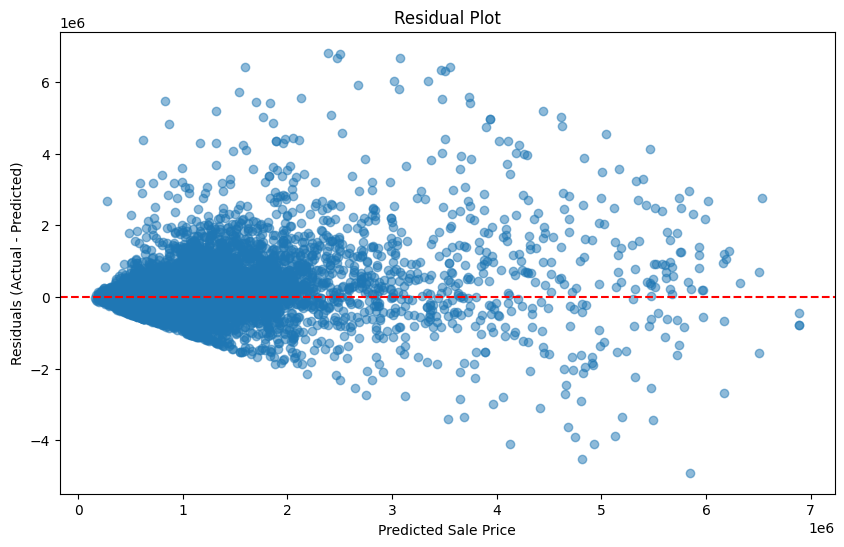

In [40]:
# visualize residuals, should be scattered around 0
import matplotlib.pyplot as plt

residuals = true_prices - preds

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(preds, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Sale Price')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.show()

# some high residuals and a lot of clustering

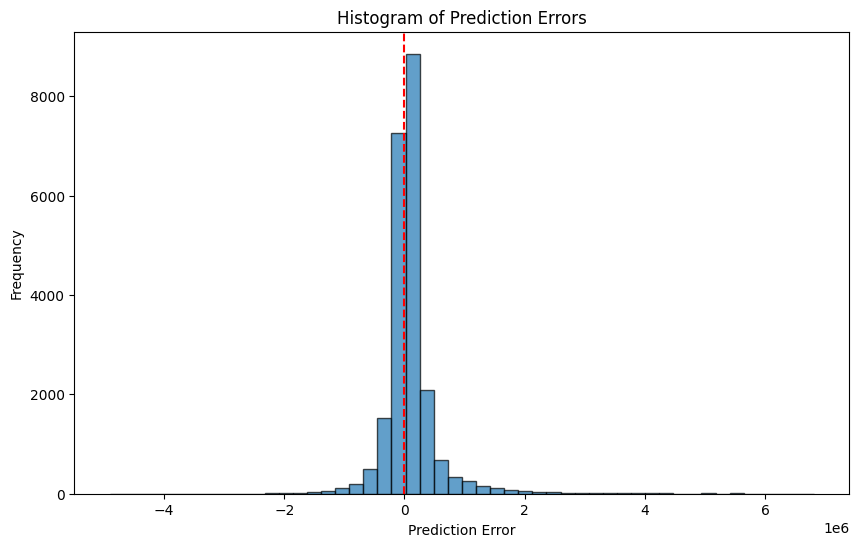

In [41]:
# visualize prediction errors, should be centered around 0 
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.title('Histogram of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()

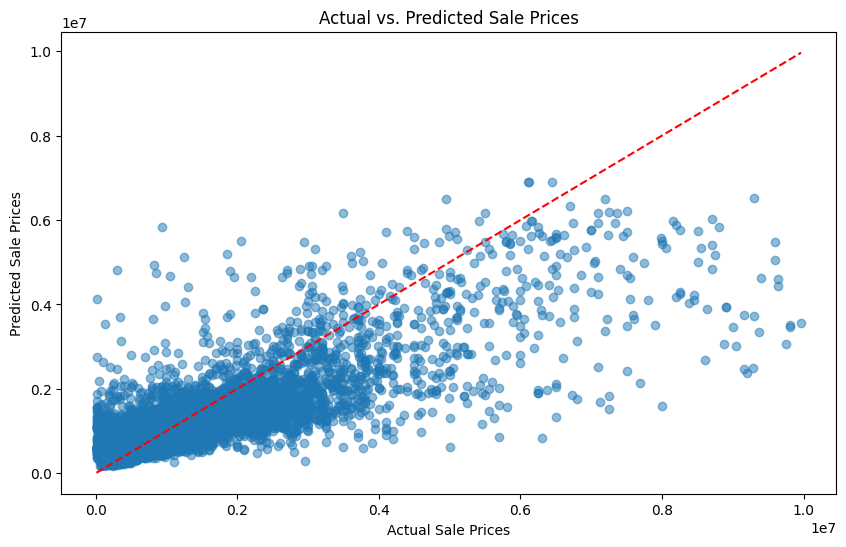

In [42]:
# compare actual vs predicted values, should be close to x = y
plt.figure(figsize=(10, 6))
plt.scatter(true_prices, preds, alpha=0.5)
plt.plot([true_prices.min(), true_prices.max()], [true_prices.min(), true_prices.max()], 'r--')
plt.xlabel('Actual Sale Prices')
plt.ylabel('Predicted Sale Prices')
plt.title('Actual vs. Predicted Sale Prices')
plt.show()

### Confusion Matrix

Classification Report:
               precision    recall  f1-score   support

         Low       0.85      0.73      0.79     44179
      Medium       0.57      0.01      0.02      2845
        High       0.81      0.92      0.86     65625

    accuracy                           0.82    112649
   macro avg       0.74      0.56      0.56    112649
weighted avg       0.82      0.82      0.81    112649



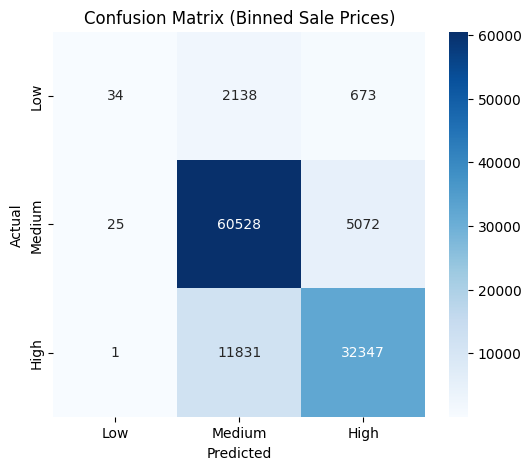

In [ ]:
bins = [0, np.log1p(200000), np.log1p(800000), np.inf]
labels = ['Low', 'Medium', 'High']
y_binned = pd.cut(y, bins=bins, labels=labels)

log_preds = cross_val_predict(pipeline, X, y, cv=cv)
preds_binned = pd.cut(log_preds, bins=bins, labels=labels)

cm = confusion_matrix(y_binned, preds_binned, labels=labels)
report = classification_report(y_binned, preds_binned, target_names=labels)

print("Classification Report:\n", report)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Binned Sale Prices)')
plt.show()

### Feature Importance

  original_column  importance
0    NEIGHBORHOOD    0.872795
1             ZIP    0.046388
2            grid    0.026560
3        BUILDING    0.025886
4           GROSS    0.021773
5            LAND    0.003679
6            YEAR    0.002920


/tmp/ipykernel_4719/4253969179.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_importance, x='importance', y='original_column', palette='viridis')


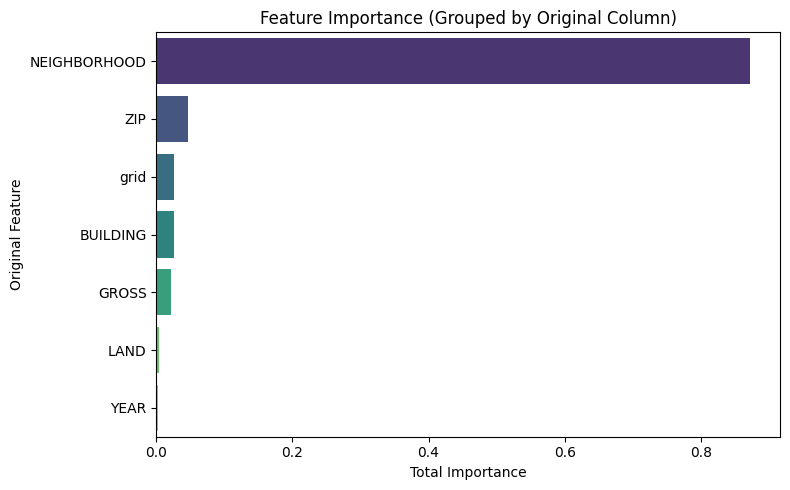

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt 

importances = pipeline.named_steps['model'].feature_importances_

feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame of importances
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

def map_to_original_col(transformed_feature):
    if transformed_feature.startswith('num__'):
        return transformed_feature.replace('num__', '').split('_')[0]
    elif transformed_feature.startswith('cat__'):
        return transformed_feature.replace('cat__', '').split('_')[0]
    else:
        return transformed_feature

importance_df['original_column'] = importance_df['feature'].apply(map_to_original_col)

grouped_importance = (
    importance_df.groupby('original_column')['importance']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

print(grouped_importance)

plt.figure(figsize=(8, 5))
sns.barplot(data=grouped_importance, x='importance', y='original_column', palette='viridis')
plt.title('Feature Importance (Grouped by Original Column)')
plt.xlabel('Total Importance')
plt.ylabel('Original Feature')
plt.tight_layout()
plt.show()



### Prototype for Real Estate Price Prediction

In [ ]:
def predict_sale_price(neighborhood, building_class, sqft, land_sqft, year_built, zip_code, grid_value):
    """
    Predict sale price using the full set of required features.

    Parameters:
    - neighborhood (str): Neighborhood name (e.g., 'Midwood')
    - building_class (str): Building class category (e.g., '01 ONE FAMILY DWELLINGS')
    - sqft (float): Gross square feet
    - land_sqft (float): Land square feet
    - year_built (int): Year the property was built
    - zip_code (int): ZIP code
    - grid_value (float): Grid value (e.g., from spatial clustering)
    """
    # Clean and format inputs
    neighborhood = neighborhood.strip().upper()
    building_class = building_class.strip().upper()
    
    # Prepare DataFrame with ALL required columns
    input_data = pd.DataFrame({
        'NEIGHBORHOOD': [neighborhood],
        'BUILDING_CLASS_CATEGORY': [building_class],
        'GROSS_SQUARE_FEET': [sqft],
        'LAND_SQUARE_FEET': [land_sqft],
        'YEAR_BUILT': [year_built],
        'ZIP_CODE': [zip_code],
        'grid': [grid_value]
    })
    
    log_pred_price = pipeline.predict(input_data)[0]
    pred_price = np.expm1(log_pred_price)

    print(f"🏠 Predicted Sale Price in {neighborhood.title()} ({building_class.title()})")
    print(f"➡️ Size: {sqft:,} sqft | Land: {land_sqft:,} sqft | Year Built: {year_built} | ZIP: {zip_code} | Grid: {grid_value}")
    print(f"💰 Estimated Sale Price: ${pred_price:,.0f}")
    
    return pred_price


In [ ]:
predict_sale_price(
    neighborhood='Midwood',
    building_class='01 ONE FAMILY DWELLINGS',
    sqft=2500,
    land_sqft=3000,
    year_built=1950,
    zip_code=11230,
    grid_value=5  
)


🏠 Predicted Sale Price in Midwood (01 One Family Dwellings)
➡️ Size: 2,500 sqft | Land: 3,000 sqft | Year Built: 1950 | ZIP: 11230 | Grid: 5
💰 Estimated Sale Price: $1,279,249


np.float32(1279249.2)